In [2]:
from __future__ import print_function

import numpy
import pandas
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy


plt.ion()

In [3]:

def imshow(tensor, title=None):
    unloader = transforms.ToPILImage()   # reconvert into PIL image
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [4]:
class ContentLoss(nn.Module):

    def __init__(self, target, type="L2"):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()
        self.type=type

    def forward(self, input):
        if self.type=="L2":
            self.loss = F.mse_loss(input, self.target)
        elif self.type=="L1":
            self.loss = F.smooth_l1_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature, type="L2"):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.type=type

    def forward(self, input):
        G = gram_matrix(input)
        if self.type=="L2":
            self.loss = F.mse_loss(G, self.target)
        elif self.type=="L1":
            self.loss = F.smooth_l1_loss(G, self.target)

        return input

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers,
                               style_layers, loss_type="L2"):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target, type=loss_type)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature, type=loss_type)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, content_layers,
                               style_layers, num_steps=300,
                       style_weight=1000000, content_weight=1, loss_type="L2"):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img, content_layers,
                               style_layers, loss_type=loss_type)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    total_loss = []
    style_loss = []
    content_loss = []
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            total_loss.append(loss.item())
            style_loss.append(style_score.item())
            content_loss.append(content_score.item())

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()


            return style_score + content_score

        optimizer.step(closure)

    losses = {}
    losses["total_loss"] = total_loss
    losses["style_loss"] = style_loss
    losses["content_loss"] = content_loss

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img, losses



def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def image_loader(image_name, imsize):
    
    loader = transforms.Compose([
        transforms.Resize((imsize, imsize)),  # scale imported image
        transforms.ToTensor()])  # transform it into a torch tensor

    image = Image.open(image_name).convert('RGB')
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [5]:
# !mkdir "./data"
# !mkdir "./data/images"
# !mkdir "./data/images/neural-style/"

# !wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg -P ./data/images/neural-style/
# !wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg -P ./data/images/neural-style/

In [6]:
# from google.colab import files

# imgs = files.upload()

In [7]:
!ls

images	images.zip  sample_data


In [8]:
!unzip images.zip -d ./images

Archive:  images.zip
replace ./images/images/content/content_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [9]:
import os

os.listdir("./images/images/content")
os.listdir("./images/images/style")

['style_1.jpg', 'style_4.jpg', 'style_3.jpg', 'style_2.jpg']

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

# style_img = image_loader("./data/images/neural-style/picasso.jpg", imsize)
# content_img = image_loader("./data/images/neural-style/dancing.jpg", imsize)

contents = sorted(os.listdir("./images/images/content"))
styles = sorted(os.listdir("./images/images/style"))

In [25]:
contents, styles

(['content_1.jpg', 'content_2.jpg', 'content_3.jpg', 'content_4.jpg'],
 ['style_1.jpg', 'style_2.jpg', 'style_3.jpg', 'style_4.jpg'])

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()


In [ ]:
cnn = models.resnet18(pretrained=True).features.to(device).eval()

In [ ]:
outputs_imgs = []
style_imgs = []
conten_imgs = []

for style, content in zip(styles, contents):
    print(style, content)

    style_img = image_loader("./images/images/style/"+style, imsize)
    content_img = image_loader("./images/images/content/"+content, imsize)


    assert style_img.size() == content_img.size(), \
        "we need to import style and content images of the same size"

    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


    cnn = models.vgg19(pretrained=True).features.to(device).eval()

    # input_img = content_img.clone()

    input_img = content_img.clone().detach().requires_grad_(True)
    # if you want to use white noise instead uncomment the below line:
    # input_img = torch.randn(content_img.data.size(), device=device)

    # desired depth layers to compute style/content losses :
    content_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
    style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    output, losses = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                content_img, style_img, input_img, content_layers_default,
                                style_layers_default, num_steps=500, loss_type="L2")
    
    outputs_imgs.append(output)
    style_imgs.append(style_img)
    conten_imgs.append(content_img)

    losses = pandas.DataFrame(losses)
    losses.to_csv("AIvengers_"+(style.split(".")[0]).split("_")[-1]+".csv", index=False)

style_1.jpg content_1.jpg
Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


run [50]:
Style Loss : 259.469177 Content Loss: 122.217171

run [100]:
Style Loss : 99.747002 Content Loss: 113.041885

run [150]:
Style Loss : 53.964520 Content Loss: 101.515488

run [200]:
Style Loss : 33.215244 Content Loss: 91.891327

run [250]:
Style Loss : 24.647514 Content Loss: 84.690506

run [300]:
Style Loss : 15.817461 Content Loss: 79.596375

run [350]:
Style Loss : 12.199353 Content Loss: 75.959297

run [400]:
Style Loss : 8.903888 Content Loss: 73.277283

run [450]:
Style Loss : 7.445285 Content Loss: 70.990189

run [500]:
Style Loss : 12.929435 Content Loss: 68.624207

style_2.jpg content_2.jpg
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 66.935951 Content Loss: 62.041199

run [100]:
Style Loss : 169.630630 Content Loss: 66.614655

run [150]:
Style Loss : 37.250492 Content Loss: 73.449471

run [200]:
Style Loss : 48.588268 Content Loss: 73.724220

run [250]:
Style Loss : 29632256.000000 Content Loss: 2436.620605

run [300]:
Style Loss : 309.690

In [ ]:
for style_img, content_img, output in zip(style_imgs, conten_imgs, outputs_imgs):
    plt.figure()
    imshow(style_img, title='Style Image')

    plt.figure()
    imshow(content_img, title='Content Image')

    plt.figure()
    imshow(output, title='Output Image')

    # sphinx_gallery_thumbnail_number = 4
    plt.ioff()
    plt.show()

In [30]:
from google.colab import files


In [28]:
!ls

AIvengers_1.csv  AIvengers_3.csv  images      sample_data
AIvengers_2.csv  AIvengers_4.csv  images.zip


In [34]:


files.download('AIvengers_4.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
os.listdir(".")

['.config',
 'AIvengers_3.csv',
 'AIvengers_4.csv',
 'images',
 'AIvengers_1.csv',
 'AIvengers_2.csv',
 'images.zip',
 'sample_data']

IndexError: ignored

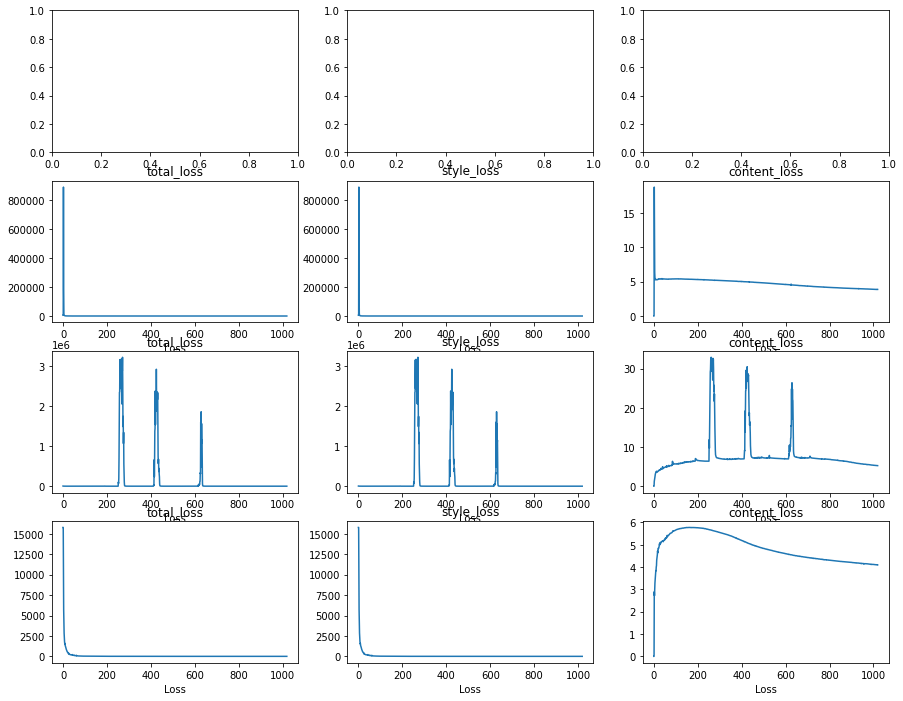

In [50]:

teams = ["AIvengers"]
path = "./"

# fig = plt.figure(fgsize=(15, 12))

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for team in teams:
    for row, file in enumerate(sorted(os.listdir(path))):            
        if ".csv" in file:
            img_ = (file.split(".")[0]).split("_")[-1]

            losses = pandas.read_csv(path+file)
            for col, colname in enumerate(losses.columns):
                axs[row, col].plot(losses[colname], label=team)
                axs[row, col].set_title(colname)
                axs[row, col].set_xlabel("iteration")
                axs[row, col].set_ylabel("Loss")

fig.tight_layout(rect=[0, 0.03, 1, 0.95]) 


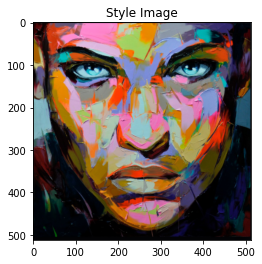

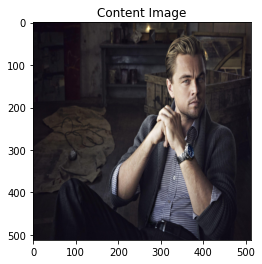

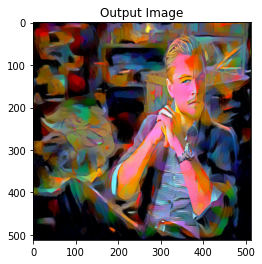

In [18]:
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [41]:
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
# euclidean_distances(output.detach().cpu().numpy().flatten().reshape(-1, 1), style_img.cpu().numpy().flatten().reshape(-1, 1))

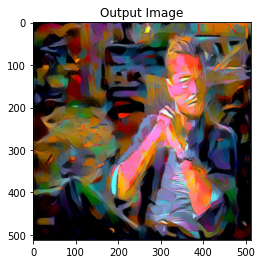

In [27]:
losses

,total_loss,style_loss,content_loss
0,1.072864e+04,1.072864e+04,0.000000e+00
1,1.072750e+04,1.072750e+04,2.282652e-07
2,1.674922e+07,1.674854e+07,6.787848e+02
3,5.443695e+06,5.443230e+06,4.646986e+02
4,4.489362e+05,4.488072e+05,1.289687e+02
...,...,...,...
315,4.673837e+01,1.359732e+01,3.314105e+01
316,4.661773e+01,1.352617e+01,3.309157e+01
317,4.802715e+01,1.511573e+01,3.291142e+01
318,5.004471e+01,1.716223e+01,3.288248e+01
